In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import sys
import math
import matplotlib
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from tifffile import imread
from glob import glob
from scipy.stats import mode
from collections import Counter
import math
import skimage
import re
from itertools import chain
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from functools import partial
import matplotlib.animation as animation
import networkx as nx
from tifffile import imread

sys.path.append("./")
import analysis as an
from importlib import reload

In [2]:
# quantify the first image

imDir = "/scratch/indikar_root/indikar1/cstansbu/woundHealing/images/"

exps = ['C1', 'CX4', 'L4']

time = None
images = {}
segments = {}

for f in os.listdir(imDir):
    fullpath = f"{imDir}{f}"
    imId = f.split(".")[0]
    num = re.sub("[^0-9]", "", imId)
    geo = re.sub("[^a-zA-Z]", "", imId)

    if not imId in exps:
        continue
    

    
    if "processed" in f:
        im = imread(fullpath, key=time)
        print(f"{f} {im.shape=}")
        images[imId] = im

    if "segmented" in f:
        im = imread(fullpath, key=time)
        print(f"{f} {im.shape=}")
        segments[imId] = im
    
print('done')

CX4.segmented.tiff im.shape=(97, 1298, 1500)
C1.processed.tiff im.shape=(3, 97, 873, 1207)
C1.segmented.tiff im.shape=(97, 873, 1207)
L4.processed.tiff im.shape=(3, 97, 1510, 620)
CX4.processed.tiff im.shape=(3, 97, 1298, 1500)
L4.segmented.tiff im.shape=(97, 1510, 620)
done


45hr


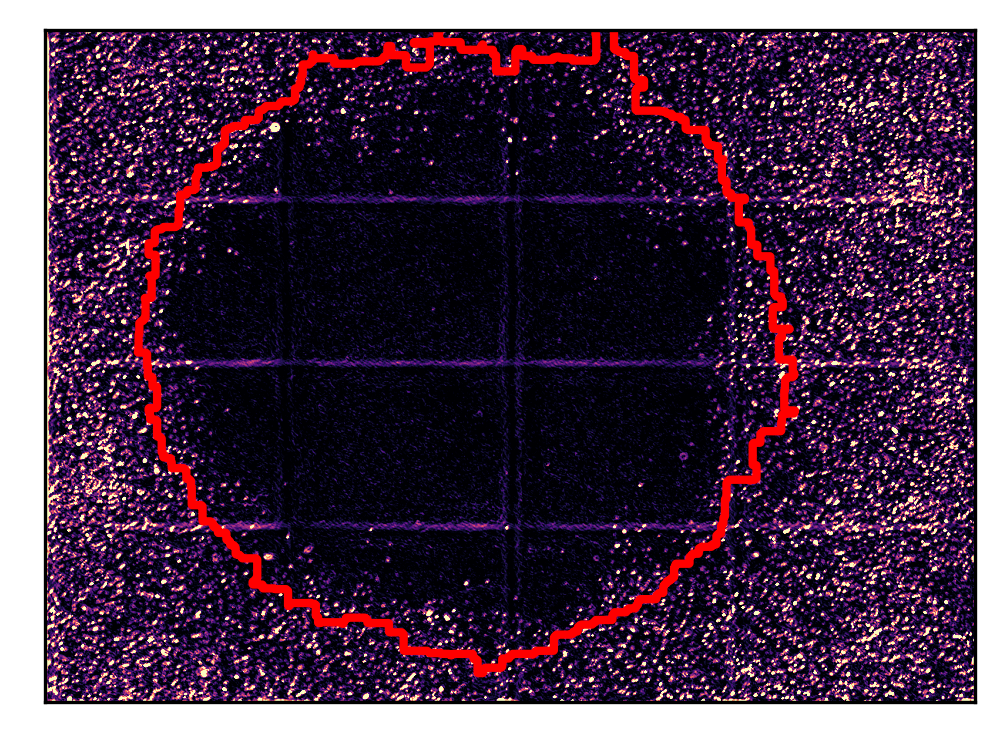

In [16]:
reload(an)

time = 90
channel = 1

imId = "C1"
img = images[imId][channel, time, : :]
seg = segments[imId][time, :, :]

foot = skimage.morphology.square
t = 1
q = 4
dilation = [25]
# wound = an.get_wound_area(img, foot, t, q, dilation)
# contours = skimage.measure.find_contours(wound)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4
fig, ax = plt.subplots()

ax.imshow(img, 
          cmap="magma", 
          vmin=0, 
          vmax=30)

ax.set_xticks([])
ax.set_yticks([])
print(f"{int((time * 30) / 60)}hr")
# timeString = "{" + f"{int((time * 30) / 60)}" "}" 
# ax.set_title(rf'Line Wound $t_{timeString}$')

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='r')



In [ ]:
break

# Area Quantification

In [19]:
# get change in  wound area over time

foot = skimage.morphology.square
t = 1
q = 4
dilation = [25]

# time samling
start = 10
end = 90
nstep = 90

times = np.linspace(start, end, nstep, dtype='int')
channel = 0

res = []

for imId in exps:
    for time in times:
        img = images[imId][channel, time, :, :]
        wound = an.get_wound_area(img, foot, t, q, dilation)

        row = {
            'imId' : imId,
            'time' : time,
            'hours' : (time * 30) / 60,
            'wound_size' : np.sum(wound),
            'wound_perc' : np.sum(wound) / wound.size,
        }
        res.append(row)

res = pd.DataFrame(res)
res.head()

imId  time  hours  wound_size  wound_perc
0   C1    10    5.0      511586    0.485509
1   C1    10    5.0      511586    0.485509
2   C1    11    5.5      503239    0.477587
3   C1    12    6.0      500375    0.474869
4   C1    13    6.5      500411    0.474903

Text(0.5, 0, 'Time (hr)')

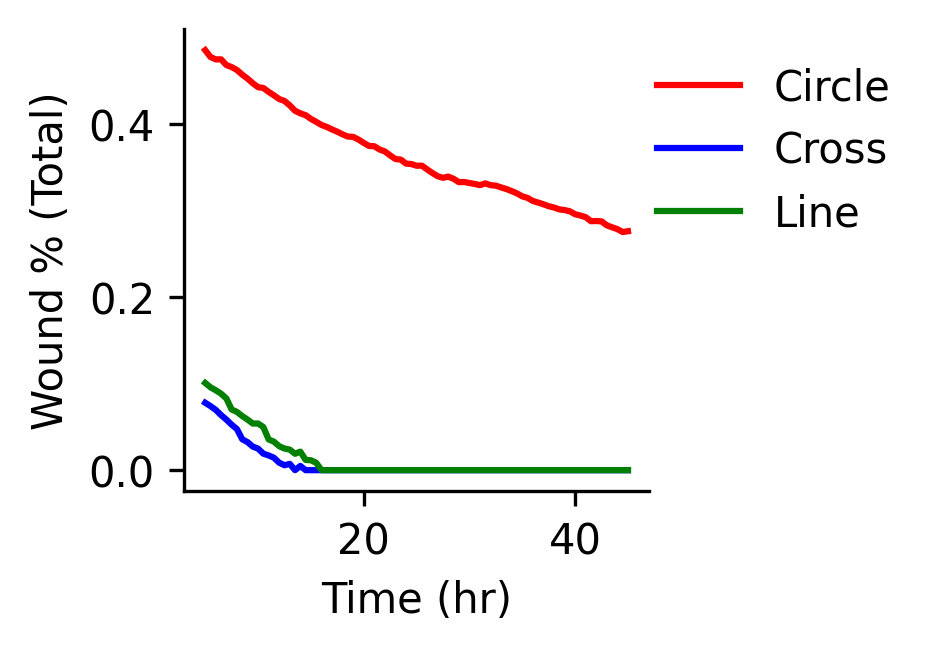

In [29]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 2

pdf = res.copy()

shapeMap = {
    "L4" : "Line",
    "C1" : "Circle",
    "CX4" : "Cross",
}

pdf['wound_shape'] = pdf['imId'].map(shapeMap)

sns.lineplot(data=pdf, 
             x='hours',
             y='wound_perc',
             hue='wound_shape',
             lw=1.5,
             palette=['r', 'b', 'g'])

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                frameon=False,
                title="",
                bbox_to_anchor=(1.6, 1),
                )

plt.ylabel("Wound % (Total)")
plt.xlabel("Time (hr)")

Text(0.5, 0, 'Time (hr)')

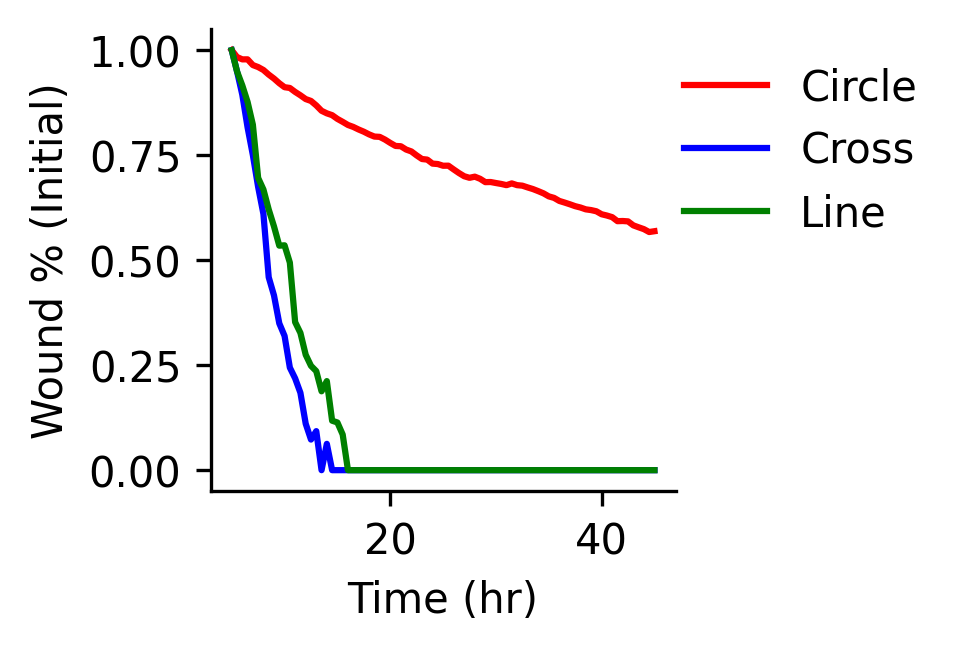

In [30]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 2

pdf = res.copy()

shapeMap = {
    "L4" : "Line",
    "C1" : "Circle",
    "CX4" : "Cross",
}

pdf['wound_shape'] = pdf['imId'].map(shapeMap)
pdf['wound_max'] = pdf.groupby(['imId'])['wound_size'].transform('max')
pdf['wound_perc_of_max'] = pdf['wound_size'] / pdf['wound_max']

sns.lineplot(data=pdf, 
             x='hours',
             y='wound_perc_of_max',
             hue='wound_shape',
             lw=1.5,
             palette=['r', 'b', 'g'])

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                frameon=False,
                title="",
                bbox_to_anchor=(1.6, 1),
                )

plt.ylabel("Wound % (Initial)")
plt.xlabel("Time (hr)")

# Number of Migrating Cells

In [32]:
# get the initial wound mask
foot = skimage.morphology.square
t = 1
q = 4
dilation = [25]

time = 10
channel = 0

wounds = {}

for imId in exps:
    img = images[imId][channel, time, :, :]
    wound = an.get_wound_area(img, foot, t, q, dilation)
    wounds[imId] = wound
      
print('done')

done


In [61]:
# get the cell data
dirpath = "/scratch/indikar_root/indikar1/cstansbu/woundHealing/segmentation/"
cdf = []

for f in os.listdir(dirpath):
    fullpath = f"{dirpath}{f}"
    imId = f.split(".")[0]
    num = re.sub("[^0-9]", "", imId)
    geo = re.sub("[^a-zA-Z]", "", imId)

    if not imId in exps:
        continue
    
    if ".celldata.csv" in f:
        tmp = pd.read_csv(fullpath)
        tmp['imId'] = imId # A HAH!
        print(f"{f} {tmp.shape=}")
        cdf.append(tmp)
        
cdf = pd.concat(cdf)
print(f"{cdf.shape=}")
cdf.head()

CX4.celldata.csv tmp.shape=(421802, 21)
L4.celldata.csv tmp.shape=(104653, 21)
C1.celldata.csv tmp.shape=(197452, 21)
cdf.shape=(723907, 21)


area  area_convex  area_filled  axis_major_length  axis_minor_length   
0  51.0         56.0         51.0           8.649601           7.542387  \
1  97.0        106.0         97.0          12.209922          10.168971   
2  86.0         92.0         86.0          11.318208           9.760898   
3  81.0         86.0         81.0          11.770306           8.824168   
4  67.0         72.0         67.0           9.358959           9.118413   

    centroid_y   centroid_x  eccentricity   
0   688.058824   102.019608      0.489519  \
1   717.680412  1305.938144      0.553507   
2  1067.418605  1313.837209      0.506216   
3  1105.740741   727.888889      0.661781   
4   370.835821   995.940299      0.225264   

                                           intensity     intensity_max  ...   
0  [[[  0   0   0]\n  [  0   0   0]\n  [  0   0  ...  [245.  26. 134.]  ...  \
1  [[[ 0  0  0]\n  [ 0  0  0]\n  [ 0  0  0]\n  [ ...     [93. 48. 45.]  ...   
2  [[[  0   0   0]\n  [  0   0   0]\n  [  0   0  ...  [217.  37.  33.]  ...   
3  [[[ 0  0  0]\n  [ 0  0  0]\n  [ 0  0  0]\n  [ ...     [ 0. 21.  0.]  ...   
4  [[[  0   0   0]\n  [  0   0   0]\n  [  0   0  ...  [162.  22.   8.]  ...   

                             intensity_mean label  orientation  perimeter   
0  [106.39215686  10.47058824  30.29411765]     1    -0.319898  24.727922  \
1     [ 1.95876289 18.05154639 13.21649485]     2     0.050946  35.798990   
2     [36.53488372 13.03488372  5.6627907 ]     3     0.209300  32.727922   
3        [0.         7.66666667 0.        ]     4    -0.160075  33.213203   
4     [16.65671642  8.98507463  2.68656716]     5     0.454666  28.142136   

   solidity                                              slice circularity  t   
0  0.910714      (slice(684, 693, None), slice(99, 107, None))    1.048105  0  \
1  0.915094   (slice(712, 725, None), slice(1301, 1312, None))    0.951130  0   
2  0.934783  (slice(1062, 1073, None), slice(1309, 1319, No...    1.008954  0   
3  0.941860   (slice(1100, 1112, None), slice(724, 733, None))    0.922727  0   
4  0.930556    (slice(366, 376, None), slice(992, 1001, None))    1.063091  0   

       prob  imId  
0  0.871829   CX4  
1  0.865969   CX4  
2  0.857943   CX4  
3  0.848942   CX4  
4  0.847249   CX4  

[5 rows x 21 columns]

In [70]:
# count over time
time = 10
p = 0.4 # probability threshold

area_lower_bound = 20
area_upper_bound = 60

res = []

for imId in exps:
    print(imId)
    wound = wounds[imId]

    tdf = cdf[cdf['imId'] == imId]

    # some QC
    tdf = tdf[tdf['t'] >= time]
    tdf = tdf[tdf['prob'] > p]
    tdf = tdf[tdf['area_convex'] > area_lower_bound]
    tdf = tdf[tdf['area_convex'] < area_upper_bound]
    tdf = tdf.reset_index()
    
    # get extraneous 
    tdf = tdf[tdf['centroid_x'] < wound.shape[1]]
    tdf = tdf[tdf['centroid_y'] < wound.shape[0]]

    tdf['i'] = tdf['centroid_y'].astype(int)
    tdf['j'] = tdf['centroid_x'].astype(int)

    tdf['is_wound'] = tdf[['i', 'j']].apply(lambda x: wound[x[0], x[1]], axis=1)
    res.append(tdf)

res = pd.concat(res)
print(f"{res.shape=}")
res.head()

C1
CX4
L4
res.shape=(601741, 25)


index  area  area_convex  area_filled  axis_major_length   
0  19383  53.0         57.0         53.0          12.242686  \
1  19385  34.0         36.0         34.0          10.281106   
2  19386  54.0         57.0         54.0           9.789562   
3  19388  39.0         39.0         39.0           9.457055   
4  19391  47.0         51.0         47.0           7.740471   

   axis_minor_length  centroid_y   centroid_x  eccentricity   
0           5.701038  870.113208   349.056604      0.884959  \
1           4.267999  870.676471   654.058824      0.909762   
2           7.087528  335.444444  1104.685185      0.689812   
3           5.337277  870.256410    43.000000      0.825522   
4           7.725485  256.085106  1012.085106      0.062197   

                                           intensity  ...  perimeter   
0  [[[ 0  0  0]\n  [ 0  0  0]\n  [ 0  0  0]\n  [ ...  ...  28.278175  \
1  [[[  0   0   0]\n  [  0  14   0]\n  [  0  24  ...  ...  21.035534   
2  [[[ 0  0  0]\n  [ 0  0  0]\n  [ 0  0  0]\n  [ ...  ...  25.313708   
3  [[[  0   0   0]\n  [  0   0   0]\n  [  3  32  ...  ...  21.656854   
4  [[[  0   0   0]\n  [  5   8   2]\n  [ 30  23  ...  ...  23.313708   

   solidity                                             slice  circularity   
0  0.929825    (slice(867, 873, None), slice(343, 355, None))     0.832881  \
1  0.944444    (slice(869, 873, None), slice(650, 660, None))     0.965565   
2  0.947368  (slice(332, 340, None), slice(1101, 1110, None))     1.058991   
3  1.000000      (slice(868, 873, None), slice(39, 48, None))     1.044922   
4  0.921569  (slice(253, 261, None), slice(1009, 1017, None))     1.086638   

    t      prob  imId    i     j  is_wound  
0  10  0.839904    C1  870   349     False  
1  10  0.829400    C1  870   654     False  
2  10  0.828811    C1  335  1104     False  
3  10  0.813087    C1  870    43     False  
4  10  0.809311    C1  256  1012     False  

[5 rows x 25 columns]

Text(0.5, 0, 'Time (hr)')

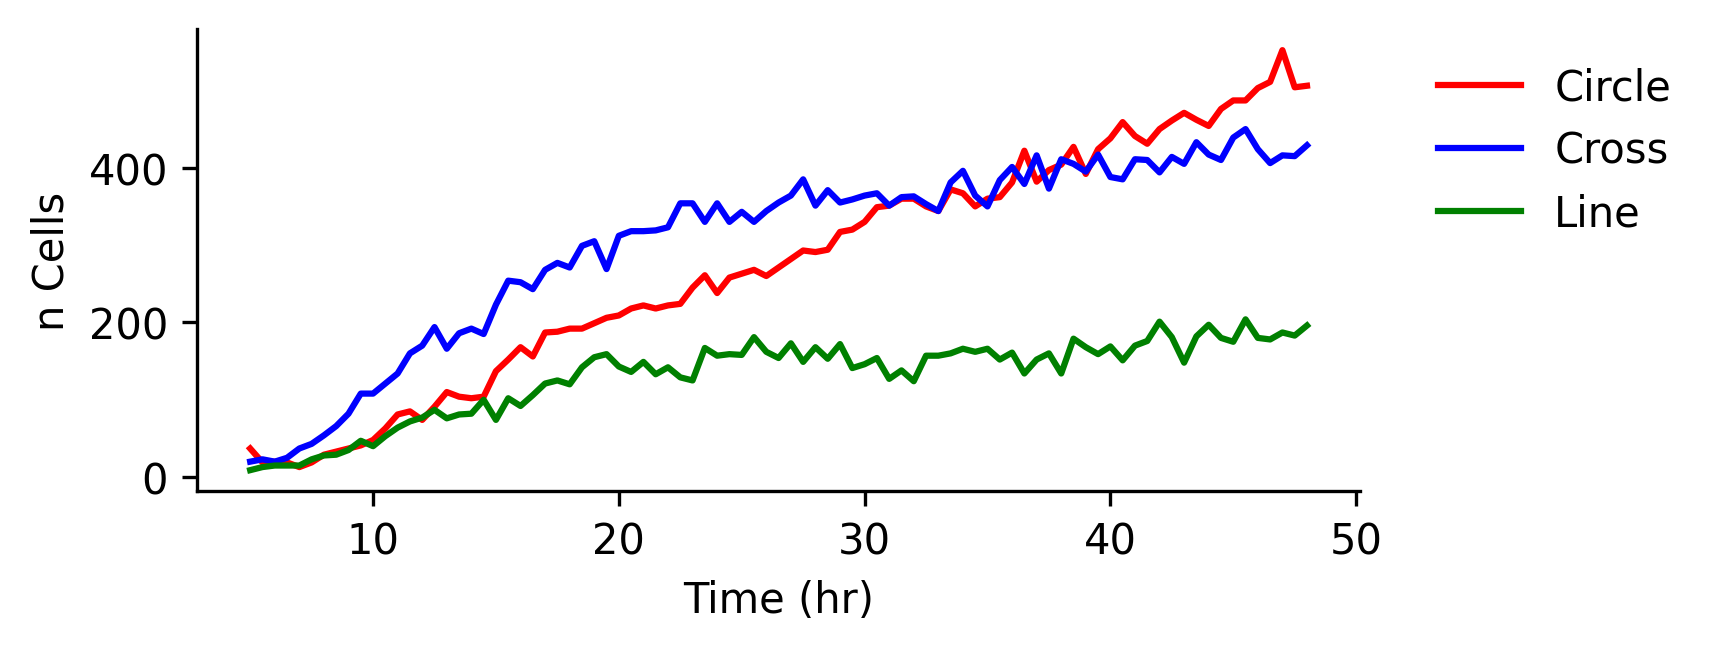

In [74]:
pdf = res.copy()

pdf = pdf[pdf['is_wound'] == True].reset_index()
gx = pdf.groupby(['imId', 't'])['i'].count().reset_index(drop=False)
gx['hours'] =  (gx['t'] * 30) / 60

gx['wound_shape'] = gx['imId'].map(shapeMap)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 2

sns.lineplot(data=gx,
             x='hours',
             y='i',
             hue='wound_shape',
             lw=1.5,
             palette=['r', 'b', 'g'])


sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                frameon=False,
                title="",
                bbox_to_anchor=(1.3, 1),
                )

plt.ylabel("n Cells")
plt.xlabel("Time (hr)")

# Analysis of Tracks

In [104]:
# get the cell data
dirpath = "/scratch/indikar_root/indikar1/cstansbu/woundHealing/tracks/"
cdf = []

for f in os.listdir(dirpath):
    fullpath = f"{dirpath}{f}"
    imId = f.split(".")[0]
    num = re.sub("[^0-9]", "", imId)
    geo = re.sub("[^a-zA-Z]", "", imId)

    if not imId in exps:
        continue
    
    if "full" in f:
        tmp = pd.read_csv(fullpath)
        tmp['imId'] = imId # A HAH!
        print(f"{f} {tmp.shape=}")
        cdf.append(tmp)
        
cdf = pd.concat(cdf)
print(f"{cdf.shape=}")
print()
print(cdf.columns)
cdf.head()

CX4.tracks.full.csv tmp.shape=(457232, 45)
L4.tracks.full.csv tmp.shape=(116681, 45)
C1.tracks.full.csv tmp.shape=(210377, 45)
cdf.shape=(784290, 45)

Index(['ID', 't', 'x', 'y', 'z', 'parent', 'root', 'state', 'generation',
       'dummy', 'area_x', 'area_y', 'area_convex', 'area_filled',
       'axis_major_length', 'axis_minor_length', 'eccentricity',
       'c0_intensity_max', 'c1_intensity_max', 'c2_intensity_max',
       'c0_intensity_min', 'c1_intensity_min', 'c2_intensity_min',
       'c0_intensity_mean', 'c1_intensity_mean', 'c2_intensity_mean', 'label',
       'prob', 'orientation', 'perimeter', 'solidity', 'circularity',
       'c0_logFoldChange_prepared', 'c1_logFoldChange_prepared',
       'c2_logFoldChange_prepared', 'c0_pval_prepared', 'c1_pval_prepared',
       'c2_pval_prepared', 'c0_logFoldChange_processed',
       'c1_logFoldChange_processed', 'c2_logFoldChange_processed',
       'c0_pval_processed', 'c1_pval_processed', 'c2_pval_processed', 'imId'],
      dtype='obje

ID  t            x            y    z  parent  root  state  generation   
0   690  0   102.019608   688.058824  0.0     690   690      5           0  \
1   597  0  1305.938144   717.680412  0.0     597   597      5           0   
2  1885  0  1313.837209  1067.418605  0.0    1885  1885      5           0   
3  1757  0   727.888889  1105.740741  0.0    1757  1757      5           0   
4  3560  0   995.940299   370.835821  0.0    3560  3560      5           0   

   dummy  ...  c0_pval_prepared  c1_pval_prepared  c2_pval_prepared   
0  False  ...      1.897082e-07               1.0          0.574258  \
1  False  ...      1.000000e+00               1.0          1.000000   
2  False  ...      1.311865e-04               1.0          1.000000   
3  False  ...      1.000000e+00               1.0          1.000000   
4  False  ...      4.870074e-02               1.0          1.000000   

   c0_logFoldChange_processed  c1_logFoldChange_processed   
0                    2.530019                    1.119235  \
1                   -0.960157                    1.572622   
2                    1.581090                    1.404123   
3                   -1.805455                    0.898563   
4                    0.789800                    1.028797   

   c2_logFoldChange_processed  c0_pval_processed  c1_pval_processed   
0                    1.777718       1.247372e-07       1.112576e-09  \
1                    0.965139       9.999996e-01       6.833629e-21   
2                    0.357493       5.949498e-05       1.986941e-19   
3                   -1.333944       1.000000e+00       1.279311e-13   
4                   -0.235331       2.251305e-02       7.552630e-11   

   c2_pval_processed  imId  
0       3.140713e-06   CX4  
1       5.077631e-11   CX4  
2       1.090558e-02   CX4  
3       1.000000e+00   CX4  
4       9.995263e-01   CX4  

[5 rows x 45 columns]

In [107]:
# count over time
time = 10

res = []

for imId in exps:
    print(imId)
    wound = wounds[imId]

    tdf = cdf[cdf['imId'] == imId]

    # some QC
    tdf = tdf[tdf['t'] >= time]
    tdf = tdf.reset_index()
    
    # get extraneous 
    tdf = tdf[tdf['x'] < wound.shape[1]]
    tdf = tdf[tdf['y'] < wound.shape[0]]

    tdf['i'] = tdf['y'].astype(int)
    tdf['j'] = tdf['x'].astype(int)

    tdf['is_wound'] = tdf[['i', 'j']].apply(lambda x: wound[x[0], x[1]], axis=1)
    res.append(tdf)

res = pd.concat(res)
print(f"{res.shape=}")
res.head()

C1
CX4
L4
res.shape=(696976, 49)


index    ID   t            x           y    z  parent  root  state   
0  20509  2916  10   349.056604  870.113208  0.0    2916  2916      5  \
1  20510  1111  10    50.657143   68.085714  0.0    1111  1111      5   
2  20511  2911  10   654.058824  870.676471  0.0    2911  2911      5   
3  20512  4127  10  1104.685185  335.444444  0.0    4127  4127      5   
4  20513  1924  10  1051.263889  425.166667  0.0    1924  1924      5   

   generation  ...  c0_logFoldChange_processed  c1_logFoldChange_processed   
0           0  ...                   -1.332613                    2.070630  \
1           0  ...                    0.107838                    1.556218   
2           0  ...                   -1.185138                    1.965269   
3           0  ...                    1.325825                    1.518247   
4           0  ...                    3.105871                    2.109483   

   c2_logFoldChange_processed  c0_pval_processed  c1_pval_processed   
0                    0.614776       1.000000e+00       2.187862e-14  \
1                    1.667822       4.261603e-01       5.656593e-16   
2                    0.331981       1.000000e+00       7.245218e-09   
3                   -0.948952       7.076819e-05       4.485246e-12   
4                    2.191157       5.015462e-13       3.755934e-18   

   c2_pval_processed  imId    i     j  is_wound  
0       7.366804e-05    C1  870   349     False  
1       2.495052e-15    C1   68    50     False  
2       2.274676e-02    C1  870   654     False  
3       1.000000e+00    C1  335  1104     False  
4       2.846915e-16    C1  425  1051     False  

[5 rows x 49 columns]

In [204]:
# enters into wound, create network

imId = "CX4"

## initial data set up

pdf = res.copy()
pdf = pdf[pdf['imId'] == imId]
pdf['enters'] = pdf.groupby(['ID'])['is_wound'].transform('max')
pdf = pdf[pdf['enters'] == True].reset_index(drop=True)

# # sampling tracks
# sampleSize = 500
# sampleIds = np.random.choice(pdf['ID'], sampleSize, replace=False)
# pdf = pdf[pdf['ID'].isin(sampleIds)]


"""Graph data construction """
## groupby the ids
pdf = pdf.sort_values(by=['ID', 't'])
gx = pdf.groupby('ID')

edges = []
pos = {}

for i, group in gx:
    startNode = group['index'].head(1).values[0]
    endNode = group['index'].tail(1).values[0]

    # we don't consider self loops
    if startNode == endNode:
        continue

    startPos = group[['x', 'y']].head(1).values[0]
    endPos = group[['x', 'y']].tail(1).values[0]

    # store positions
    pos[startNode] = startPos
    pos[endNode] = endPos

    # build edge dataframe
    row = {
        'source' : startNode,
        'target' : endNode,
        'distance' : np.linalg.norm(endPos - startPos),
        'track_id' : i,
    }
    edges.append(row)

edges = pd.DataFrame(edges)
print(f"{edges.shape=}")

edges.head()

edges.shape=(5474, 4)


source  target   distance  track_id
0   58226  178403  49.837648       336
1   56438  263276  47.246876       512
2   56262  453716  75.706903       641
3   56679  373815  50.759952       650
4   58206  455280  79.668549       677

In [168]:
# edge filtering
# edges = edges[edges['distance'] > 10]

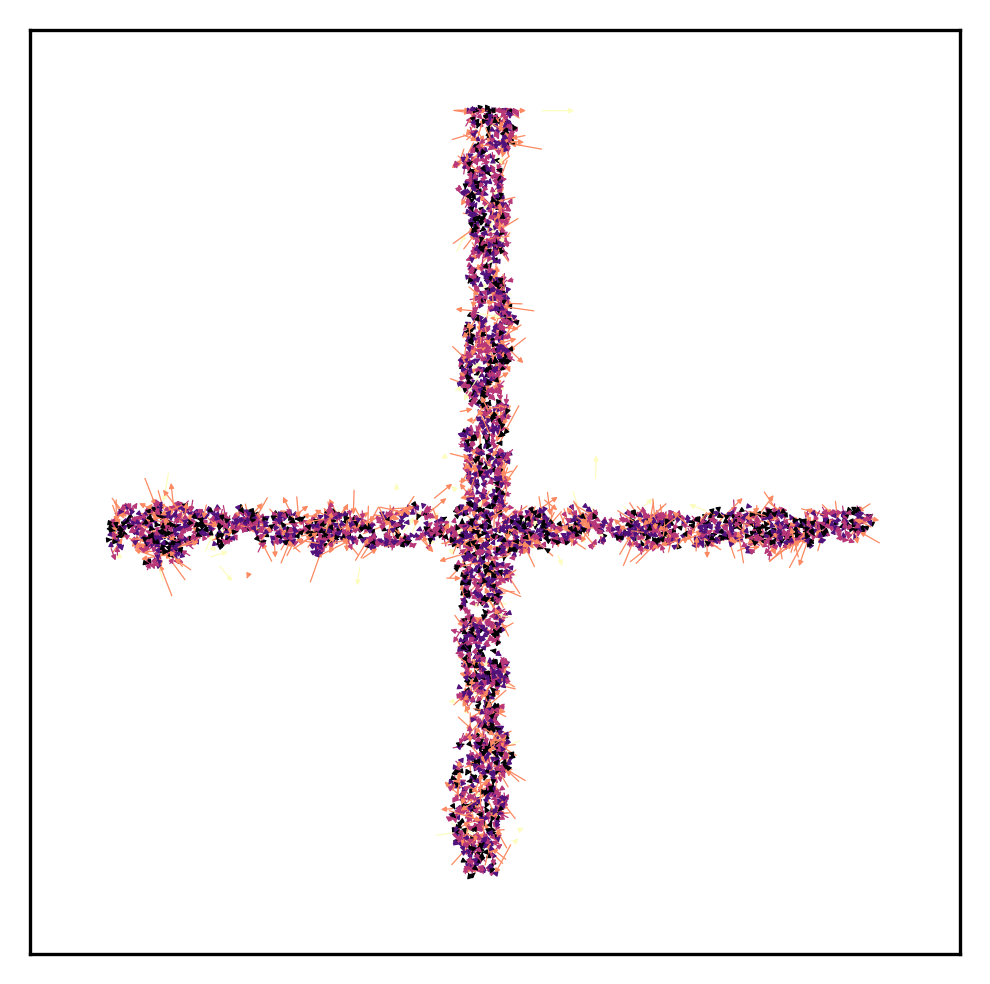

In [205]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "none"
plt.rcParams['figure.figsize'] = 4, 4

kedges = edges[edges['distance'] > 1]

# make the graph object
G = nx.from_pandas_edgelist(kedges, 
                            source='source',
                            target='target',
                            # create_using=nx.DiGraph(),
                            edge_attr=True)

G.pos = pos

# plotting params
lut = 10
cmap = plt.cm.get_cmap('magma', lut=5)
fig, ax = plt.subplots()

# node coloring
# centrality = nx.eigenvector_centrality(G, weight=relationship, tol=0.001)
# colors = [centrality[n] for n in G.nodes()]

# network plots
# nx.draw_networkx_nodes(G,
#                        pos=G.pos,
#                        node_size=2,
#                        # node_color=colors,
#                        node_color='lightgrey',
#                        # cmap=cmap,
#                        # alpha=0.75,
#                        edgecolors='k',
#                        linewidths=0.3,
#                        ax=ax)

eweights = np.array([e['distance'] for node1, node2, e in G.edges(data=True)])
eweights = [np.log(x) for x in eweights]

_ = nx.draw_networkx_edges(G,
                       pos=G.pos,
                       width=0.3,
                       # edge_color='k',
                       edge_color=eweights,
                       edge_cmap=cmap,
                       # edge_vmin=0, 
                       # edge_vmax=0.1,
                       arrows=True,
                       arrowstyle="-|>",
                       arrowsize=2.5,
                       # alpha=0.3,
                       ax=ax)   

# ax.set_aspect('equal')
# ax.invert_yaxis()
# ax.axis('off')

(-0.5, 1499.5, 1297.5, -0.5)

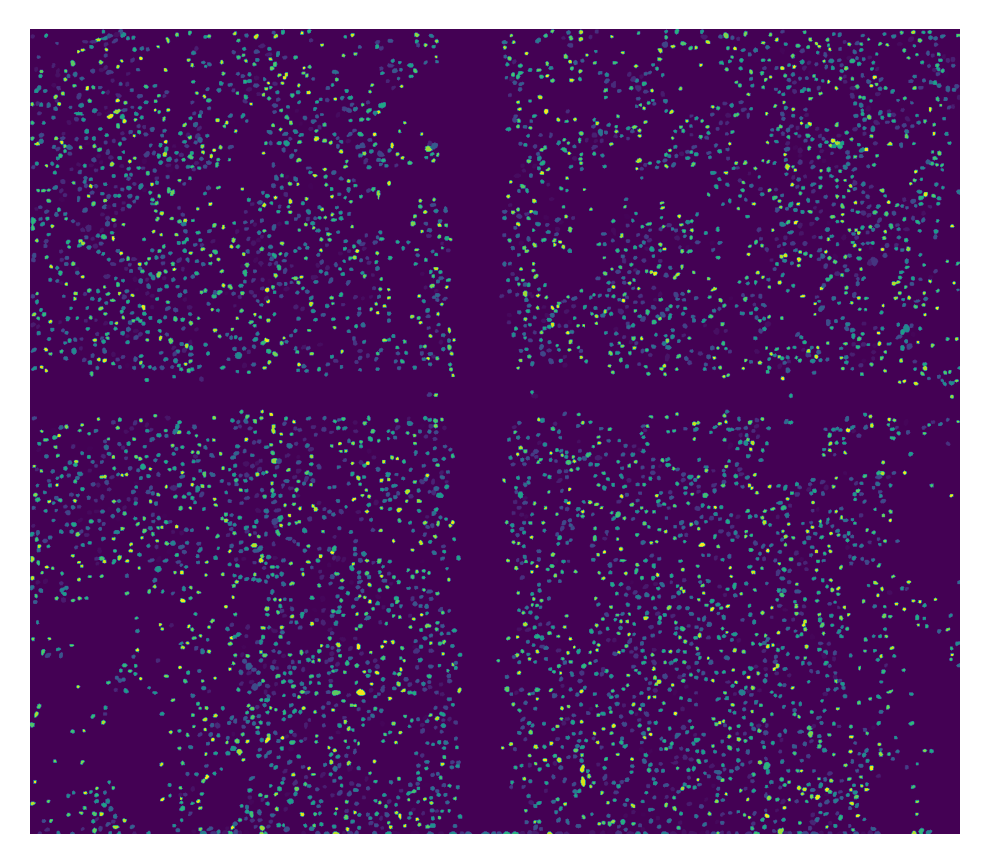

In [209]:
plt.imshow(segments['CX4'][10])
plt.axis(False)

In [ ]:
break

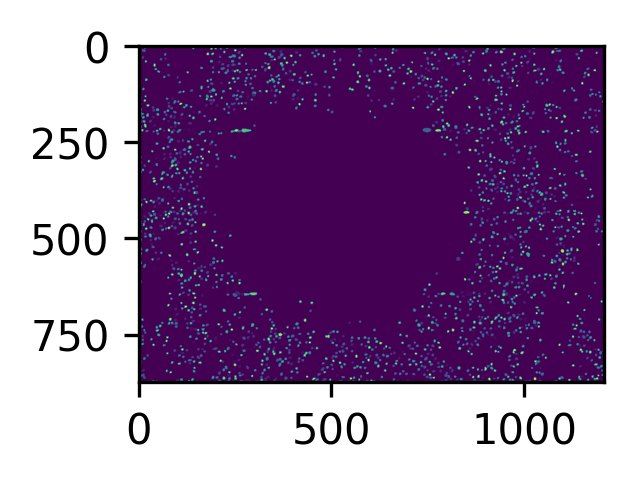

In [68]:
plt.imshow(segments['C1'][90])

(1510, 620)
(166035, 27)
is_wound
False    142378
True      23657
Name: count, dtype: int64


<AxesSubplot: xlabel='j', ylabel='i'>

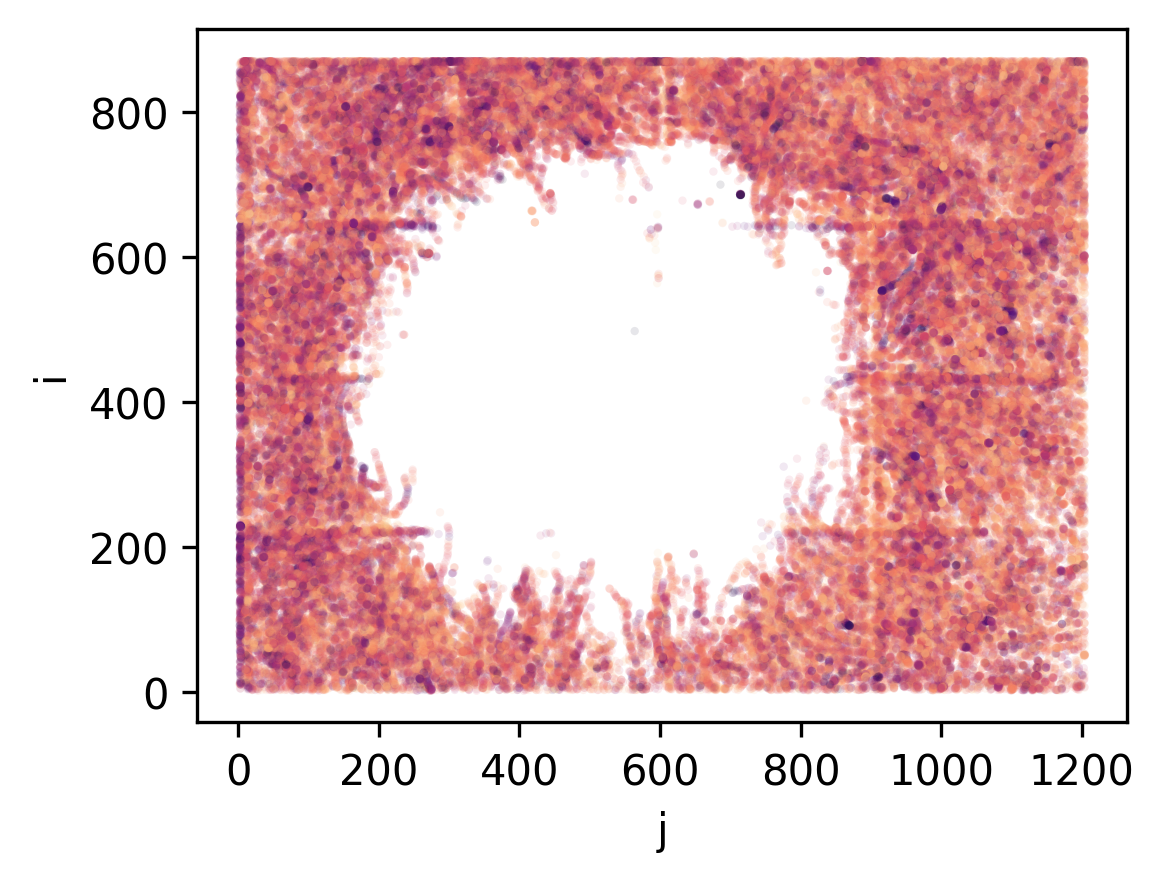

In [102]:
# plt.imshow(wound, zorder=1)
print(wound.shape)

pdf = res[res['imId'] == 'C1'].reset_index()
pdf['alpha'] = (pdf['t'] / pdf['t'].max())
# pdf = pdf[pdf['t'] == 20]
print(f"{pdf.shape}")
print(f"{pdf['is_wound'].value_counts()}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 3


sns.scatterplot(data=pdf, 
                x='j',
                y='i',
                c=pdf['area'].to_list(),
                s=4,
                ec='None',
                # alpha=pdf['alpha'].to_list(),
                alpha=0.1,
                cmap='magma_r',
                legend=False)


In [75]:
# # plt.imshow(wound, zorder=1)
# print(wound.shape)

# pdf = res[res['imId'] == 'C1']
# pdf = pdf[pdf['t'] == 20]
# print(f"{pdf.shape}")
# print(f"{pdf['is_wound'].value_counts()}")

# # test = tdf[tdf['t'] == 10]
# # test = test[test['centroid_x'] < wound.shape[1]]
# # test = test[test['centroid_y'] < wound.shape[0]]

# # print(test['centroid_y'].max())
# # print(test['centroid_x'].max())

# sns.scatterplot(data=pdf, 
#                 x='j',
#                 y='i',
#                 hue='is_wound',
#                 legend=False,
#                 size=1)


In [ ]:
# # store all of them

# exps = ['C1', 'CX4', 'L4']

# # parameters
# foot = skimage.morphology.square
# t = 1
# q = 4
# dilation = [25]

# wounds = {}

# for exp in exps:
#     img = images[exp]
#     wound = get_wound_area(img, foot, t, q, dilation)
#     wounds[exp] = wound
#     print(f"{exp=} {wound.shape}")

# print('done')

In [ ]:
impath = '/scratch/indikar_root/indikar1/cstansbu/woundHealing/images/C1.processed.tiff'

img = imread(fullpath)
print(f"{img.shape=}")

In [ ]:
?imread

In [ ]:
(10 * 30) / 60

In [ ]:
# ?skimage.morphology.convex_hull_image

In [ ]:
tracksDir = "/scratch/indikar_root/indikar1/cstansbu/woundHealing/tracks/"

tracks = []

for f in os.listdir(tracksDir):
    if "full" in f:
        imId = f.split(".")[0]
        num = re.sub("[^0-9]", "", imId)
        geo = re.sub("[^a-zA-Z]", "", imId)
        
        fullpath = f"{tracksDir}{f}"
        df = pd.read_csv(fullpath)
        df['imId'] = imId
        df['num'] = num
        df['geo'] = geo
        tracks.append(df)
        print(f"{imId=} {df.shape=}")
        
tracks = pd.concat(tracks)
print(f"{tracks.shape=}")
print()
print(tracks['geo'].value_counts())
tracks.head()

In [ ]:
df.head()